In [21]:
using Revise, Dates, DataFrames, ExcelFiles, Plots, CSV, Statistics
using ReproductionNumbers

In [22]:
case_name   =   "estimated-cases-20200511"
file_name   =   "data/COVID19_Deutschland.xlsx"
sheet_name  =   "Nowcast_R"
days_col    =   "Datum RKI-Tagesbericht"
data_col    =   "N(RKI-H)"

"N(RKI-H)"

In [23]:
function get_data(df::DataFrame; days_col::String, data_col::String, kind::String)
    @assert kind ∈ ( "R", "cases" ) "kind $kind not supported"
    index = df[!, days_col]
    data = df[!, data_col]
    inds = .!ismissing.(data)

    DataFrame( Dict("days" => Vector(index[inds]), "$(kind)" => Vector(data[inds]) ) )
end


function mae(pred::Vector, gt::CSV.Column{Float64,Float64})
   mean(abs.(pred - gt))
end


mae (generic function with 1 method)

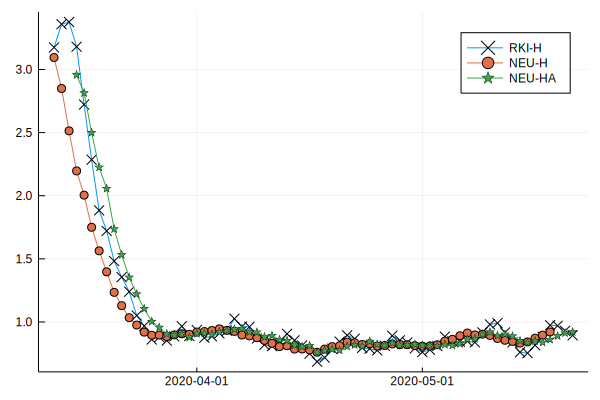

In [42]:
k_gen = 4
df = DataFrame(load(file_name, sheet_name))
df_cases = get_reference_data(df, days_col = days_col, data_col = data_col, kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases, past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases, past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal(df_cases, Day(k_gen - 1), Day(3),  Day(k_gen))


gr()
plot(rki_h_R.days, rki_h_R.R, marker=:x, label="RKI-H")
plot!(neu_h_R.days, neu_h_R.R, marker=:c, label="NEU-H")
plot!(neu_ha_R.days, neu_ha_R.R, marker=:s, label="NEU-HA")

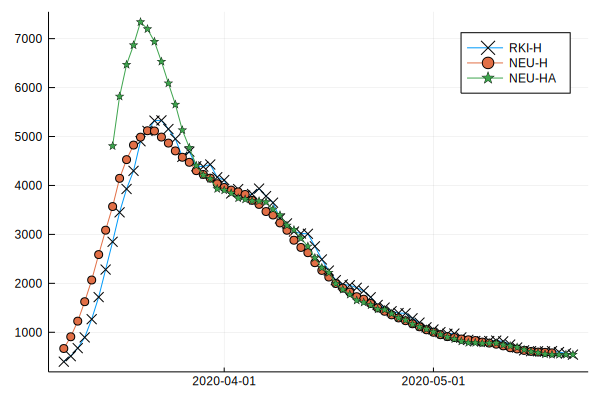

In [44]:
gr()
plot(rki_h_N.days, rki_h_N.cases, marker=:x, label="RKI-H")
plot!(neu_h_N.days, neu_h_N.cases, marker=:c, label="NEU-H")
plot!(neu_ha_N.days, neu_ha_N.cases, marker=:s, label="NEU-HA")

## No delay pattern

In [41]:
df = CSV.read("data/synth_0.9_0.95_1_day.csv")
#######################################################
# the days column of `df` needs to be converted to days for the rest to work...
#######################################################
r_true = df[!, "true R"]
index = df[!, "k"]
cases = df[!, "New cases (True)"]
df_cases = get_data(df, days_col = "k", data_col = "New cases (True)", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal(df_cases, Day(k_gen - 1), Day(3), Day(k_gen))
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)

AssertionError: AssertionError: Column `days` of df_cases  needs to have `Date` entries

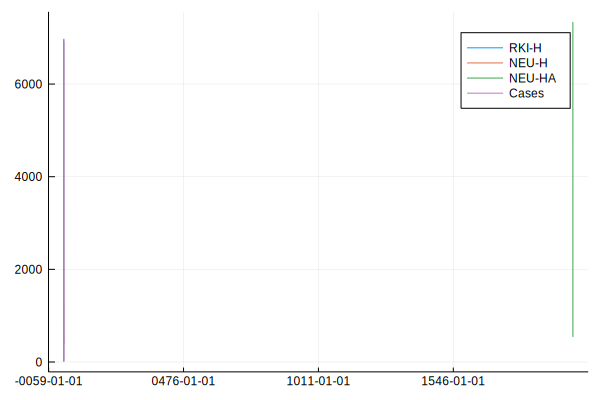

In [7]:
gr()
plot(rki_h_N.days, rki_h_N.cases, label="RKI-H")
plot!(neu_h_N.days, neu_h_N.cases, label="NEU-H")
plot!(neu_ha_N.days, neu_ha_N.cases, label="NEU-HA")
plot!(index, cases, label="Cases")

## Delayed by 10

In [8]:
df_cases = get_data(df, days_col = "k", data_col = "reported cases", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal(df_cases, k_gen - 1, 3, k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)

MethodError: MethodError: no method matching -(::Int64, ::Day)
Closest candidates are:
  -(!Matched::Dates.CompoundPeriod, ::Period) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Dates/src/periods.jl:346
  -(!Matched::DateTime, ::Period) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Dates/src/arithmetic.jl:77
  -(!Matched::Date, ::Day) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Dates/src/arithmetic.jl:75
  ...

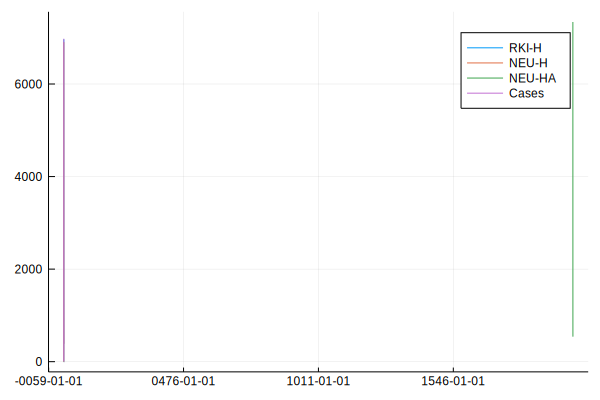

In [9]:
gr()
plot(rki_h_N.days, rki_h_N.cases, label="RKI-H")
plot!(neu_h_N.days, neu_h_N.cases, label="NEU-H")
plot!(neu_ha_N.days, neu_ha_N.cases, label="NEU-HA")
plot!(index, cases, label="Cases")

## 1 Day delay pattern

In [10]:
df_cases = get_data(df, days_col = "k", data_col = "delayed", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal(df_cases, k_gen - 1, 3, k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)


MethodError: MethodError: no method matching -(::Int64, ::Day)
Closest candidates are:
  -(!Matched::Dates.CompoundPeriod, ::Period) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Dates/src/periods.jl:346
  -(!Matched::DateTime, ::Period) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Dates/src/arithmetic.jl:77
  -(!Matched::Date, ::Day) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Dates/src/arithmetic.jl:75
  ...

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /Users/la5373/.julia/packages/Plots/qZHsp/src/args.jl:1194
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /Users/la5373/.julia/packages/Plots/qZHsp/src/args.jl:1194
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /Users/la5373/.julia/packages/Plots/qZHsp/src/args.jl:1194
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /Users/la5373/.julia/packages/Plots/qZHsp/src/args.jl:1194


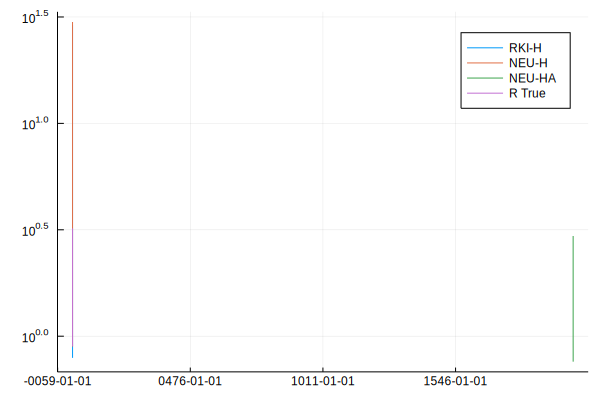

In [11]:
gr()
plot(rki_h_R.days[1:50], rki_h_R.R[1:50], label="RKI-H",yscale=:log)
plot!(neu_h_R.days[1:50], neu_h_R.R[1:50], label="NEU-H",yscale=:log)
plot!(neu_ha_R.days[1:50], neu_ha_R.R[1:50], label="NEU-HA",yscale=:log)
plot!(index[1:50], r_true[1:50], label="R True",yscale=:log)

In [12]:
gr()
plot(rki_h_R.days[100:450], rki_h_R.R[100:450], label="RKI-H")
plot!(neu_h_R.days[100:450], neu_h_R.R[100:450], label="NEU-H")
plot!(neu_ha_R.days[100:450], neu_ha_R.R[100:450], label="NEU-HA")
plot!(index[100:450], r_true[100:450], label="R True",yscale=:log)

BoundsError: BoundsError: attempt to access 67-element Array{Date,1} at index [100:450]

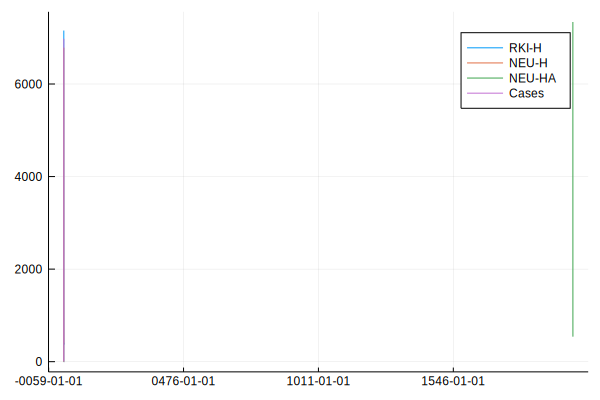

In [13]:
gr()
plot(rki_h_N.days, rki_h_N.cases, label="RKI-H")
plot!(neu_h_N.days, neu_h_N.cases, label="NEU-H")
plot!(neu_ha_N.days, neu_ha_N.cases, label="NEU-HA")
plot!(index, cases, label="Cases")

In [14]:
result = parameter_search(df, collect(1:5), collect(1:5),  collect(1:9), "delayed")
CSV.write("mae_1day.csv", result)
result

UndefVarError: UndefVarError: parameter_search not defined

# 2-Day Delay pattern

In [15]:
df = CSV.read("data/synth_0.9_0.95_1_2day.csv")
df_cases = get_data(df, days_col = "k", data_col = "delayed", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal(df_cases, k_gen - 1, 3, k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)


MethodError: MethodError: no method matching -(::Int64, ::Day)
Closest candidates are:
  -(!Matched::Dates.CompoundPeriod, ::Period) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Dates/src/periods.jl:346
  -(!Matched::DateTime, ::Period) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Dates/src/arithmetic.jl:77
  -(!Matched::Date, ::Day) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Dates/src/arithmetic.jl:75
  ...

In [16]:
result = parameter_search(df, collect(1:10), collect(1:10),  collect(1:10), "delayed")
CSV.write("mae_2day.csv", result)
result

UndefVarError: UndefVarError: parameter_search not defined

# Weekend Delay Pattern

In [17]:
df = CSV.read("data/synth_0.9_0.95_1_weekend.csv")
df_cases = get_data(df, days_col = "k", data_col = "delayed", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal(df_cases, k_gen - 1, 3, k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)


MethodError: MethodError: no method matching -(::Int64, ::Day)
Closest candidates are:
  -(!Matched::Dates.CompoundPeriod, ::Period) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Dates/src/periods.jl:346
  -(!Matched::DateTime, ::Period) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Dates/src/arithmetic.jl:77
  -(!Matched::Date, ::Day) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Dates/src/arithmetic.jl:75
  ...

# Real delay pattern

In [18]:
df = CSV.read("data/synth_german_0.9_0.95_1_real_delay_flock.csv")
df_cases = get_data(df, days_col = "k", data_col = "delayed", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal(df_cases, k_gen - 1, 3, k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)


ArgumentError: ArgumentError: "data/synth_german_0.9_0.95_1_real_delay_flock.csv" is not a valid file

In [19]:
df = CSV.read("data/synth_german_0.9_0.95_1_real_delay.csv")
df_cases = get_data(df, days_col = "k", data_col = "delayed", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal(df_cases, k_gen - 1, 3, k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)


ArgumentError: ArgumentError: "data/synth_german_0.9_0.95_1_real_delay.csv" is not a valid file

In [20]:
result = parameter_search(df, collect(1:10), collect(1:10),  collect(1:10), "delayed")
CSV.write("mae_real_delay.csv", result)
result

UndefVarError: UndefVarError: parameter_search not defined